In [ ]:
%tensorflow_version 1.x
import os
import cv2
import h5py
import json
import keras
import random 
import imageio
import numpy as np
import pandas as pd
import nibabel as nib
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
from IPython.display import Image
from keras.optimizers import Adam
from keras.engine import Input, Model
from keras.utils import to_categorical
from keras.layers.merge import concatenate
from tensorflow.compat.v1.logging import INFO, set_verbosity
from keras.layers import Activation,Conv3D,MaxPooling3D,Deconvolution3D,UpSampling3D,ConvLSTM2D

set_verbosity(INFO)
K.set_image_data_format("channels_first")

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!chmod 777 ./drive/My\ Drive/Copy\ of\ Task01_BrainTumour.tar
!sudo tar -xvf ./drive/My\ Drive/Copy\ of\ Task01_BrainTumour.tar

Task01_BrainTumour/._dataset.json
Task01_BrainTumour/dataset.json
Task01_BrainTumour/._imagesTr
Task01_BrainTumour/imagesTr/
Task01_BrainTumour/imagesTr/BRATS_457.nii.gz
Task01_BrainTumour/imagesTr/BRATS_306.nii.gz
Task01_BrainTumour/imagesTr/BRATS_206.nii.gz
Task01_BrainTumour/imagesTr/BRATS_449.nii.gz
Task01_BrainTumour/imagesTr/BRATS_318.nii.gz
Task01_BrainTumour/imagesTr/BRATS_218.nii.gz
Task01_BrainTumour/imagesTr/BRATS_434.nii.gz
Task01_BrainTumour/imagesTr/BRATS_365.nii.gz
Task01_BrainTumour/imagesTr/BRATS_265.nii.gz
Task01_BrainTumour/imagesTr/BRATS_214.nii.gz
Task01_BrainTumour/imagesTr/BRATS_314.nii.gz
Task01_BrainTumour/imagesTr/BRATS_445.nii.gz
Task01_BrainTumour/imagesTr/BRATS_269.nii.gz
Task01_BrainTumour/imagesTr/BRATS_369.nii.gz
Task01_BrainTumour/imagesTr/BRATS_438.nii.gz
Task01_BrainTumour/imagesTr/BRATS_277.nii.gz
Task01_BrainTumour/imagesTr/BRATS_377.nii.gz
Task01_BrainTumour/imagesTr/BRATS_426.nii.gz
Task01_BrainTumour/imagesTr/BRATS_095.nii.gz
Task01_BrainTumour/i

In [ ]:
# set home directory and data directory
HOME_DIR = "/content/Task01_BrainTumour/"
DATA_DIR = HOME_DIR

def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    return image, label

In [ ]:
def plot_image_grid(image):
    data_all = []

    data_all.append(image)

    fig, ax = plt.subplots(3, 6, figsize=[16, 9])

    # coronal plane
    coronal = np.transpose(data_all, [1, 3, 2, 4, 0])
    coronal = np.rot90(coronal, 1)

    # transversal plane
    transversal = np.transpose(data_all, [2, 1, 3, 4, 0])
    transversal = np.rot90(transversal, 2)

    # sagittal plane
    sagittal = np.transpose(data_all, [2, 3, 1, 4, 0])
    sagittal = np.rot90(sagittal, 1)

    for i in range(6):
        n = np.random.randint(coronal.shape[2])
        ax[0][i].imshow(np.squeeze(coronal[:, :, n, :]))
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])
        if i == 0:
            ax[0][i].set_ylabel('Coronal', fontsize=15)

    for i in range(6):
        n = np.random.randint(transversal.shape[2])
        ax[1][i].imshow(np.squeeze(transversal[:, :, n, :]))
        ax[1][i].set_xticks([])
        ax[1][i].set_yticks([])
        if i == 0:
            ax[1][i].set_ylabel('Transversal', fontsize=15)

    for i in range(6):
        n = np.random.randint(sagittal.shape[2])
        ax[2][i].imshow(np.squeeze(sagittal[:, :, n, :]))
        ax[2][i].set_xticks([])
        ax[2][i].set_yticks([])
        if i == 0:
            ax[2][i].set_ylabel('Sagittal', fontsize=15)

    fig.subplots_adjust(wspace=0, hspace=0)


In [ ]:
def get_labeled_image(image, label, is_categorical=False):
    if not is_categorical:
        label = to_categorical(label, num_classes=4).astype(np.uint8)

    image = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(
        np.uint8)

    labeled_image = np.zeros_like(label[:, :, :, 1:])

    # remove tumor part from image
    labeled_image[:, :, :, 0] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 1] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 2] = image * (label[:, :, :, 0])

    # color labels
    labeled_image += label[:, :, :, 1:] * 255
    return labeled_image


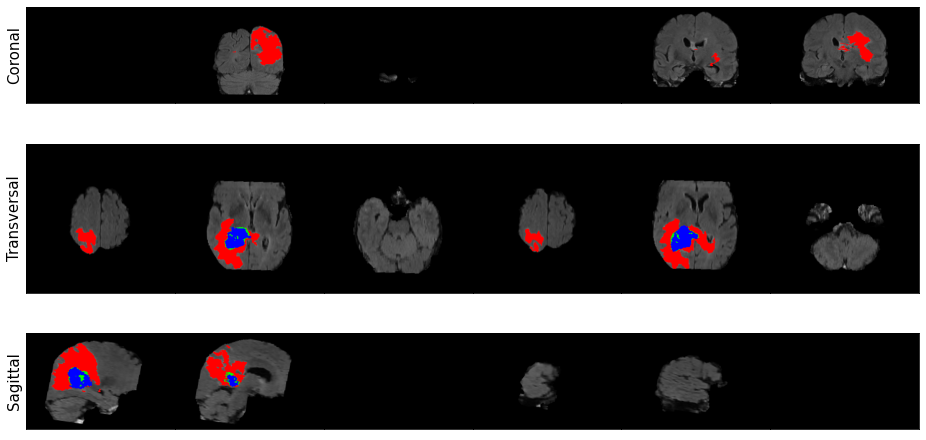

In [ ]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")
image = get_labeled_image(image, label)

plot_image_grid(image)

In [ ]:
def get_sub_volume(image, label, 
                   orig_x = 240, orig_y = 240, orig_z = 155, 
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95):
   
    # Initialize features and labels with `None`
    X = None
    y = None
    tries = 0
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        start_x = np.random.randint(0, orig_x - output_x+1)
        start_y = np.random.randint(0, orig_y - output_y+1)
        start_z = np.random.randint(0, orig_z - output_z+1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        # One-hot encode the categories.
        # (output_x, output_y, output_z, num_classes)
        y = keras.utils.to_categorical(y, num_classes=num_classes)

        # compute the background ratio
        bgrd_ratio = np.sum(y[:, :, :, 0])/(output_x * output_y * output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            X = np.moveaxis(X, 3, 0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y, 3, 0)
            
            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]
    
            return X, y

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")

In [ ]:
def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, 0], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, 0], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)


In [ ]:
def visualize_patch_pred(X, y,z):
    fig, ax = plt.subplots(1, 3, figsize=[9, 3], squeeze=False)

    ax[0][0].imshow(X[:, :, 0], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, 0], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])
    ax[0][2].imshow(z[:, :, 0], cmap='Reds')
    ax[0][2].set_xticks([])
    ax[0][2].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

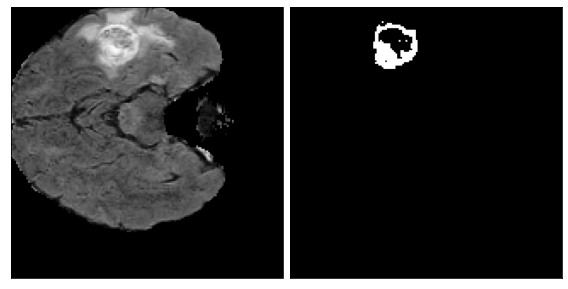

In [ ]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_301.nii.gz", DATA_DIR + "labelsTr/BRATS_301.nii.gz")
X, y = get_sub_volume(image, label)
# enhancing tumor is channel 2 in the class label
# you can change indexer for y to look at different classes
visualize_patch(X[0, :, :, :], y[2])

In [ ]:
def standardize(image):
    # initialize to array of zeros, with same shape as the image
    standardized_image = np.zeros(image.shape)

   
    for c in range(image.shape[0]):   # iterate over channels
        
        for z in range(image.shape[3]):  # iterate over the `z` dimension
            
            image_slice = image[c,:,:,z]  # get a slice of the image 
            
            # subtract the mean from image_slice
            centered = image_slice-np.mean(image_slice)
            if np.std(image_slice)!=0:
                centered_scaled = centered/np.std(image_slice)
            else:
                centered_scaled=centered

            
            standardized_image[c, :, :, z] = centered_scaled  # update  the slice of standardized image

    ### END CODE HERE ###

    return standardized_image

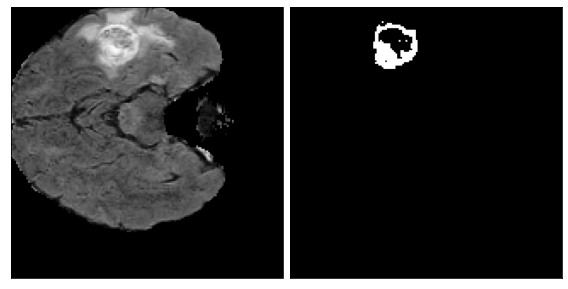

In [ ]:
X_norm = standardize(X)
visualize_patch(X_norm[0, :, :, :], y[2])


In [ ]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):

    
    dice_numerator = 2. * tf.keras.backend.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = tf.keras.backend.sum(y_true*y_true, axis=axis) + tf.keras.backend.sum(y_pred* y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean(dice_numerator/ dice_denominator) 
    

    return dice_coefficient

In [ ]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):

    dice_numerator = 2. * tf.keras.backend.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = tf.keras.backend.sum(y_true*y_true, axis=axis) + tf.keras.backend.sum(y_pred* y_pred, axis=axis) + epsilon
    dice_loss = 1- K.mean(dice_numerator/ dice_denominator) 

    return dice_loss

In [ ]:
class VolumeDataGenerator(keras.utils.Sequence):
    def __init__(self,
                 sample_list,
                 base_dir,
                 batch_size=3,
                 shuffle=True,
                 dim=(160, 160, 16),
                 num_channels=4,
                 num_classes=3,
                 verbose=1):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.dim = dim
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.verbose = verbose
        self.sample_list = sample_list
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.sample_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.sample_list) / self.batch_size))

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'

        # Initialization
        X = np.zeros((self.batch_size, self.num_channels, *self.dim),
                     dtype=np.float64)
        y = np.zeros((self.batch_size, self.num_classes, *self.dim),
                     dtype=np.float64)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            print(ID["image"])
            # print(list_IDs_temp,"i=",i,"\n ID=",ID,"\n f=")#,h5py.File(self.base_dir + ID["image"], 'r')
            # # Store sample
            # if self.verbose == 1:
            #     print("Training on: %s" % self.base_dir + ID)
            # with h5py.File(self.base_dir + ID["image"], 'r') as f:
            #     X[i] = np.array(f.get("x"))
            #     # remove the background class
            # with h5py.File(self.base_dir + ID["label"], 'r') as f:
            #     y[i] = np.moveaxis(np.array(f.get("y")), 3, 0)[1:]
            image, label = load_case(DATA_DIR + ID["image"], DATA_DIR + ID["label"])
            X[i], y[i] = get_sub_volume(image, label)
            
        print("========================")
        return X, y

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[
                  index * self.batch_size: (index + 1) * self.batch_size]
        # Find list of IDs
        sample_list_temp = [self.sample_list[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(sample_list_temp)

        return X, y

In [ ]:
def compute_class_sens_spec(pred, label, class_num):
    
    # extract sub-array for specified class
    class_pred = pred[class_num]
    class_label = label[class_num]

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute:
    
    # true positives
    tp = np.sum((label == 1) & (pred == 1))

    # true negatives
    tn = np.sum((label == 0) & (pred == 0))
    
    #false positives
    fp = np.sum((label == 0) & (pred == 1))
    
    # false negatives
    fn = np.sum((label == 1) & (pred == 0))

    # compute sensitivity and specificity
    sensitivity = tp/(tp+fn)
    specificity =  tn/(fp+tn)

    ### END CODE HERE ###

    return sensitivity, specificity

In [ ]:
#===============================================================================
#                             U-NET from Scratch
#===============================================================================

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>  Variables(Model)  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
loss_function=soft_dice_loss
input_shape=(4, 160, 160, 16)
pool_size=(2, 2, 2) 
n_labels=3
initial_learning_rate=0.00001
deconvolution=False
depth=4 
n_base_filters=32
include_label_wise_dice_coefficients=False 
metrics=[dice_coefficient]
batch_normalization=False 
activation_name="sigmoid"

#>>>>>>>>>>>>>>>>>>>>>>>>>>>> Variables(3D Conv) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
input_layer=None 
n_filters = None
batch_normalization=False
kernel=(3, 3, 3) 
activation=None
padding='same' 
strides3D=(1, 1, 1)
instance_normalization=False

#>>>>>>>>>>>>>>>>>>>>>>>>>>>> Variables(UP Conv) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
n_filters=None
pool_size=(2, 2, 2)
kernel_size=(2, 2, 2)
stridesUP=(2, 2, 2)
deconvolution=False

#===============================================================================
#                             U-NET Model Building 
#===============================================================================

#>>>>>>>>>>>>>>>>>>>>>>>>>>>> Create Input Layer <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
input_layer = Input(input_shape)
levels = list()

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  layer_depth = 0 D <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
layer_depth = 0
n_filters = n_base_filters * (2 ** layer_depth)
layer_1_1 = Conv3D(n_filters, kernel, padding=padding, strides=strides3D)(input_layer)
layer_1_1_act=Activation('relu')(layer_1_1)
layer_1_2 = Conv3D(n_filters*2, kernel, padding=padding, strides=strides3D)(layer_1_1_act)
layer_1_2_act=Activation('relu')(layer_1_2)
layer_mx3d_1 =  MaxPooling3D(pool_size=pool_size)(layer_1_2_act)

levels.append([layer_1_1_act, layer_1_2_act, layer_mx3d_1])



#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  layer_depth = 1 D <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
layer_depth = 1 
n_filters = n_base_filters * (2 ** layer_depth)
layer_2_1 = Conv3D(n_filters, kernel, padding=padding, strides=strides3D)(layer_mx3d_1)
layer_2_1_act=Activation('relu')(layer_2_1)
layer_2_2 = Conv3D(n_filters*2, kernel, padding=padding, strides=strides3D)(layer_2_1_act)
layer_2_2_act=Activation('relu')(layer_2_2)
layer_mx3d_2 =  MaxPooling3D(pool_size=pool_size)(layer_2_2_act)

levels.append([layer_2_1_act, layer_2_2_act, layer_mx3d_2])



#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  layer_depth = 2 D <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
layer_depth = 2 
n_filters = n_base_filters * (2 ** layer_depth)
layer_3_1 = Conv3D(n_filters, kernel, padding=padding, strides=strides3D)(layer_mx3d_2)
layer_3_1_act=Activation('relu')(layer_3_1)
layer_3_2 = Conv3D(n_filters*2, kernel, padding=padding, strides=strides3D)(layer_3_1_act)
layer_3_2_act=Activation('relu')(layer_3_2)
layer_mx3d_3 =  MaxPooling3D(pool_size=pool_size)(layer_3_2_act)

levels.append([layer_3_1_act, layer_3_2_act, layer_mx3d_3])



#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  layer_depth = 3 D <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
layer_depth = 3 
n_filters = n_base_filters * (2 ** layer_depth)

layer_4_1 = Conv3D(n_filters, kernel, padding=padding, strides=strides3D)(layer_mx3d_3)
layer_4_1_act=Activation('relu')(layer_4_1)
layer_4_2 = Conv3D(n_filters*2, kernel, padding=padding, strides=strides3D)(layer_4_1_act)
layer_4_2_act=Activation('relu')(layer_4_2)

levels.append([layer_4_1_act, layer_4_2_act]) 

#>>>>>>>>>>>>>>>>>>>>>>>>>  layer_depth = 3 ConvLSTM  <<<<<<<<<<<<<<<<<<<<<<<<<<<
layer_depth = 3 
n_filters = n_base_filters * (2 ** layer_depth)

layer_4_3 = ConvLSTM2D(20, (3,3), padding=padding, strides=(1, 1),return_sequences=True)(layer_4_2_act)
layer_4_3_act=Activation('relu')(layer_4_3)


levels.append([layer_4_3_act]) 


#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  layer_depth = 2 U <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
layer_depth = 2 
layer_5_up=UpSampling3D(size=pool_size)(layer_4_3_act)
layer_5_concat = concatenate([layer_5_up, levels[layer_depth][1]], axis=1)

n_filters=levels[layer_depth][1]._keras_shape[1]
layer_5_1 = Conv3D(n_filters, kernel, padding=padding, strides=strides3D)(layer_5_concat)
layer_5_1_act=Activation('relu')(layer_5_1)
layer_5_2 = Conv3D(n_filters, kernel, padding=padding, strides=strides3D)(layer_5_1_act)
layer_5_2_act=Au


#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  layer_depth = 1 U <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
layer_depth = 1 
layer_6_up=UpSampling3D(size=pool_size)(layer_5_2_act)
layer_6_concat = concatenate([layer_6_up, levels[layer_depth][1]], axis=1)

n_filters=levels[layer_depth][1]._keras_shape[1]
layer_6_1 = Conv3D(n_filters, kernel, padding=padding, strides=strides3D)(layer_6_concat)
layer_6_1_act=Activation('relu')(layer_6_1)
layer_6_2 = Conv3D(n_filters, kernel, padding=padding, strides=strides3D)(layer_6_1_act)
layer_6_2_act=Activation('relu')(layer_6_2)   



#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  layer_depth = 0 U <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
layer_depth = 0 
layer_7_up=UpSampling3D(size=pool_size)(layer_6_2_act)
layer_7_concat = concatenate([layer_7_up, levels[layer_depth][1]], axis=1)

n_filters=levels[layer_depth][1]._keras_shape[1]
layer_7_1 = Conv3D(n_filters, kernel, padding=padding, strides=strides3D)(layer_7_concat)
layer_7_1_act=Activation('relu')(layer_7_1)
layer_7_2 = Conv3D(n_filters, kernel, padding=padding, strides=strides3D)(layer_7_1_act)
layer_7_2_act=Activation('relu')(layer_7_2)  

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>    FINAL Layer    <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
final_convolution = Conv3D(n_labels, (1, 1, 1))(layer_7_2_act)
final_act = Activation(activation_name)(final_convolution)
model = Model(inputs=input_layer, outputs=final_act)

model.compile(optimizer=Adam(lr=initial_learning_rate), loss=loss_function,
                  metrics=metrics)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 160, 160,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 160, 160, 3488        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 160, 160, 0           conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 64, 160, 160, 55360       activation_1[0][0]               
___________

In [ ]:
#@title Default title text
# batch_size=3
# dim=(160, 160, 16)
# num_channels=4
# num_classes=3
# Errors=0
# X_train = np.zeros((batch_size, num_channels, *dim),dtype=np.float64)
# y_train = np.zeros((batch_size, num_classes, *dim),dtype=np.float64)
# p=[]
# q=[]
# count=0
# for I in range (len(config["training"])):
#   i=config["training"][I]
#   image, label = load_case(DATA_DIR + i["image"], DATA_DIR + i["label"])
#   try:
#     X, y = get_sub_volume(image, label)
#     print(Errors,I,i)
#     q+=[i]
#   except:
#     Errors+=1
#     p+=[i]


# path="/content/drive/My Drive/Code_my_v/pl.npy"
# Q=np.load(path, allow_pickle=True)
Data="8_07_2020_"+str(9)
model.load_weights("/content/drive/My Drive/Code_my_v/Try2"+ Data+'my_model_BT.hdf5')


In [ ]:

path="/content/drive/My Drive/Code_my_v/pl.npy"
Q=np.load(path, allow_pickle=True)


dim=(160, 160, 16)
num_channels=4
num_classes=3
batch_size=200
X1 = np.zeros((batch_size, num_channels, *dim),
                     dtype=np.float64)
X2 = np.zeros((batch_size, num_channels, *dim),
                     dtype=np.float64)
y1 = np.zeros((batch_size, num_classes, *dim),
                     dtype=np.float64)
y2 = np.zeros((batch_size, num_classes, *dim),
                     dtype=np.float64)


for i in range (batch_size):
  image, label = load_case(DATA_DIR + Q[i]["image"], DATA_DIR + Q[i]["label"])
  X1[i], y1[i] = get_sub_volume(image, label)
for i in range (batch_size):
  image, label = load_case(DATA_DIR + Q[batch_size+i]["image"], DATA_DIR + Q[batch_size+i]["label"])
  X2[i], y2[i] = get_sub_volume(image, label)


In [ ]:
for i in range (10,20):
  Data="8_07_2020_"+str(i)
  print("===========",Data,"===========")
  model.fit(X1,y1,batch_size=4)
  model.fit(X2,y2,batch_size=4)

  
  model.save_weights("/content/drive/My Drive/Code_my_v/Try2" + Data+'my_model_BT.hdf5')

#batch_size=None, epochs=1

=========== 8_07_2020_10 ===========
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1
200/200 [==============================] - 584s 3s/step - loss: 0.5151 - dice_coefficient: 0.4849
Epoch 1/1
200/200 [==============================] - 546s 3s/step - loss: 0.5421 - dice_coefficient: 0.4579
=========== 8_07_2020_11 ===========
Epoch 1/1
200/200 [==============================] - 545s 3s/step - loss: 0.5128 - dice_coefficient: 0.4872
Epoch 1/1
200/200 [==============================] - 541s 3s/step - loss: 0.5300 - dice_coefficient: 0.4700
=========== 8_07_2020_12 ===========
Epoch 1/1
200/200 [==============================] - 544s 3s/step - loss: 0.5068 - dice_coefficient: 0.4932
Epoch 1/1
200/200 [==============================] - 539s 3s/step - loss: 0.5291 - dice_coefficient: 0.4709
=========== 8_07_2020_13 ===========
Epoch 1/1
200/200 [==============================] - 541s 3s/step - loss: 0.4920 - dice_coefficient: 0.5080
E

In [ ]:
def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['Edema', 
                   'Non-Enhancing Tumor', 
                   'Enhancing Tumor'], 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    return patch_metrics

Sensitivity: 0.9439
Specificity: 0.9917


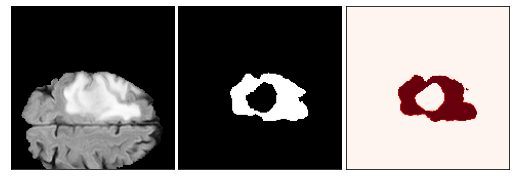

Sensitivity: 0.8477
Specificity: 0.9863


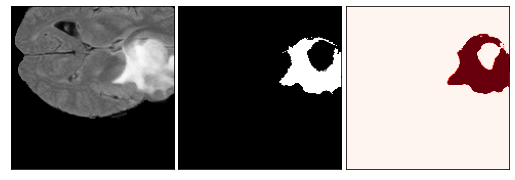

Sensitivity: 0.0775
Specificity: 0.9777


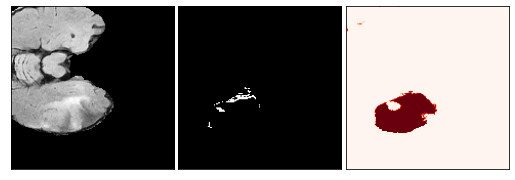

Sensitivity: 0.3262
Specificity: 0.9864


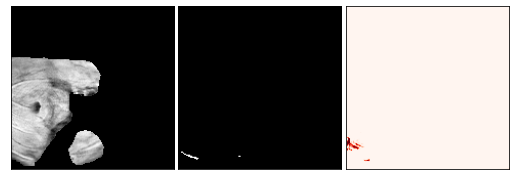

Sensitivity: 0.9817
Specificity: 0.9969


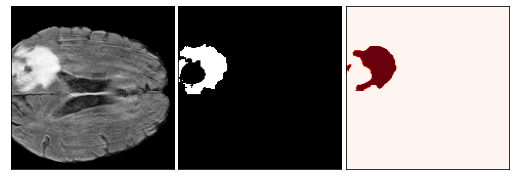

In [ ]:
dim=(160, 160, 16)
num_channels=4
num_classes=3
batch_size=5
X = np.zeros((batch_size, num_channels, *dim),
                     dtype=np.float64)
y = np.zeros((batch_size, num_classes, *dim),
                     dtype=np.float64)


  

c = random.randint(0, 400-batch_size) 
for i in range (batch_size):
  image, label = load_case(DATA_DIR + Q[i+c]["image"], DATA_DIR + Q[i+c]["label"])
  X[i], y[i] = get_sub_volume(image, label)

pred=model.predict(X)
cls=0
for i in range (batch_size) :
  sensitivity, specificity = compute_class_sens_spec(y[i], pred[i], cls)
  print(f"Sensitivity: {sensitivity:.4f}")
  print(f"Specificity: {specificity:.4f}")
  visualize_patch_pred(X[i][cls, :, :, :],y[i][cls], pred[i][cls])

Sensitivity: 0.9675
Specificity: 0.9958


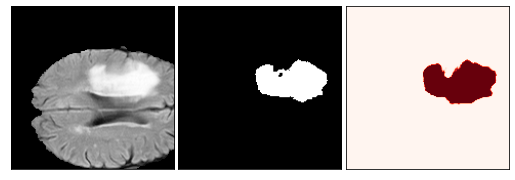

Sensitivity: 0.9675
Specificity: 0.9958


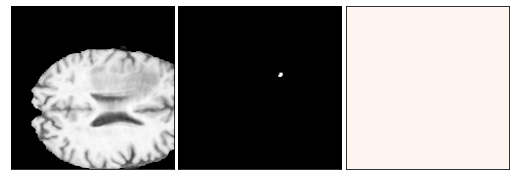

Sensitivity: 0.9675
Specificity: 0.9958


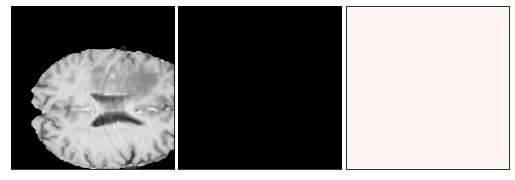

In [ ]:
dim=(160, 160, 16)
num_channels=4
num_classes=3
batch_size=1
X = np.zeros((batch_size, num_channels, *dim),
                     dtype=np.float64)
y = np.zeros((batch_size, num_classes, *dim),
                     dtype=np.float64)


  

# c = random.randint(0, 400-1) 

image, label = load_case(DATA_DIR + Q[c]["image"], DATA_DIR + Q[c]["label"])
X[0], y[0] = get_sub_volume(image, label)

pred=model.predict(X)

for i in range (num_classes) :
  sensitivity, specificity = compute_class_sens_spec(y[0], pred[0], i)
  print(f"Sensitivity: {sensitivity:.4f}")
  print(f"Specificity: {specificity:.4f}")
  visualize_patch_pred(X[0][i, :, :, :],y[0][i], pred[0][i])

In [ ]:
image.shape

(240, 240, 155, 4)

In [ ]:
X[0].shape

(4, 160, 160, 16)

In [ ]:
label.shape

(240, 240, 155)

In [ ]:
np.unique(label)

array([0., 1., 2., 3.])

In [ ]:
y[0].shape

(3, 160, 160, 16)